In [ ]:
!pip install dgl-cu100

     |████████████████████████████████| 24.6MB 132kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
from os import path

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from dgl import batch
from dgl.data.ppi import LegacyPPIDataset
from dgl.nn.pytorch import GraphConv,GATConv
from sklearn.metrics import f1_score
from torch import nn, optim
from torch.utils.data import DataLoader

import dgl.function as fn
from dgl.nn.pytorch.softmax import edge_softmax
from dgl.nn.pytorch.utils import Identity
from dgl.utils import expand_as_pair

#MODEL_STATE_FILE = "/content/drive/MyDrive/data_CS_MVA/ADL/model_state.pth"
MODEL_STATE_FILE = "/content/drive/MyDrive/model_state.pth"


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

## train-eval-test

In [ ]:
def train(model, loss_fcn, device, optimizer, train_dataloader, valid_dataset , epochs , early_stop):
    hist = {'epochs':[],'loss':[],'score_val':[]}
    max_score_val = 0
    max_patience,patience = 40,0
    for epoch in range(epochs):
        model.train()
        losses = []
        for batch, data in enumerate(train_dataloader):
            subgraph, features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            model.g = subgraph
            for layer in model.layers:
                layer.g = subgraph
            logits = model(features.float())
            loss = loss_fcn(logits, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            scores = []
            for batch, valid_data in enumerate(valid_dataset):
                subgraph, features, labels = valid_data
                features = features.clone().detach().to(device)
                labels = labels.clone().detach().to(device)
                score, _ = evaluate(features.float(), model, subgraph, labels.float(), loss_fcn)
                scores.append(score)
            score_val = np.array(scores).mean()
            print("F1-Score: {:.4f} ".format(score_val))
            hist['score_val'].append(score_val)
            hist['epochs'].append(epoch+1)
            hist['loss'].append(loss_data)
            
            if early_stop : 
              if score_val > max_score_val :
                  max_score_val = score_val
                  patience = 0 
                  torch.save(model.state_dict(), MODEL_STATE_FILE)
              else :
                  patience +=1
                  if patience >= max_patience:
                      break
            


def test(model, loss_fcn, device, test_dataloader):
    test_scores = []
    for batch, test_data in enumerate(test_dataloader):
        subgraph, features, labels = test_data
        features = features.to(device)
        labels = labels.to(device)
        test_scores.append(evaluate(features, model, subgraph, labels.float(), loss_fcn)[0])
    mean_scores = np.array(test_scores).mean()
    print("F1-Score: {:.4f}".format(np.array(test_scores).mean()))
    return mean_scores


def evaluate(features, model, subgraph, labels, loss_fcn):
    with torch.no_grad():
        model.eval()
        model.g = subgraph
        for layer in model.layers:
            layer.g = subgraph
        output = model(features.float())
        loss_data = loss_fcn(output, labels.float())
        predict = np.where(output.data.cpu().numpy() >= 0.5, 1, 0)
        score = f1_score(labels.data.cpu().numpy(), predict, average="micro")
        return score, loss_data.item()


def collate_fn(sample):
    graphs, features, labels = map(list, zip(*sample))
    graph = batch(graphs)
    features = torch.from_numpy(np.concatenate(features))
    labels = torch.from_numpy(np.concatenate(labels))
    return graph, features, labels





# Main function

In [ ]:
def main(batch_size  ,mode, epochs , early_stop = True):
    # create the dataset
    train_dataset, valid_dataset, test_dataset = LegacyPPIDataset(mode="train"), LegacyPPIDataset(mode="valid"), LegacyPPIDataset(mode="test")
    train_dataloader = DataLoader(train_dataset,batch_size, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size, collate_fn=collate_fn)
    n_features, n_classes = train_dataset.features.shape[1], train_dataset.labels.shape[1]

    # create the model, loss function and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BasicGraphModel(g=train_dataset.graph.to(device), n_layers=2, input_size=n_features,
                            hidden_size=256, output_size=n_classes, nonlinearity=F.elu,device=device).to(device)
    
    loss_fcn = nn.BCEWithLogitsLoss()
    #lr=0.005 as in the paper
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    # train and test
    if mode == "train":
        train(model, loss_fcn, device, optimizer, train_dataloader, valid_dataset , epochs , early_stop = early_stop)
        #torch.save(model.state_dict(), MODEL_STATE_FILE)
    model.load_state_dict(torch.load(MODEL_STATE_FILE))
    return test(model, loss_fcn, device, test_dataloader) 
    

# Model architecture

In [ ]:
class noGATConv(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 num_heads,
                 feat_drop=0.,
                 attn_drop=0.,
                 negative_slope=0.2,
                 residual=False,
                 activation=None,
                 device=None,
                 allow_zero_in_degree=False):
        super(noGATConv, self).__init__()
        self._num_heads = num_heads
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._allow_zero_in_degree = allow_zero_in_degree
        if isinstance(in_feats, tuple):
            self.fc_src = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
            self.fc_dst = nn.Linear(
                self._in_dst_feats, out_feats * num_heads, bias=False)
        else:
            self.fc = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
        #self.attn_l = torch.ones([1,num_heads,out_feats], dtype=torch.float64, device=device)
        self.attn_l = 1.
        #self.attn_r = torch.ones([1,num_heads,out_feats], dtype=torch.float64,device=device)
        self.attn_r = 1.
        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        self.leaky_relu = nn.LeakyReLU(negative_slope)
        if residual:
            if self._in_dst_feats != out_feats:
                self.res_fc = nn.Linear(
                    self._in_dst_feats, num_heads * out_feats, bias=False)
            else:
                self.res_fc = Identity()
        else:
            self.register_buffer('res_fc', None)
        self.reset_parameters()
        self.activation = activation

    def reset_parameters(self):
        """

        Description
        -----------
        Reinitialize learnable parameters.

        Note
        ----
        The fc weights :math:`W^{(l)}` are initialized using Glorot uniform initialization.
        The attention weights are using xavier initialization method.
        """
        gain = nn.init.calculate_gain('relu')
        if hasattr(self, 'fc'):
            nn.init.xavier_normal_(self.fc.weight, gain=gain)
        else:
            nn.init.xavier_normal_(self.fc_src.weight, gain=gain)
            nn.init.xavier_normal_(self.fc_dst.weight, gain=gain)
        #nn.init.xavier_normal_(self.attn_l, gain=gain)
        #nn.init.xavier_normal_(self.attn_r, gain=gain)
        if isinstance(self.res_fc, nn.Linear):
            nn.init.xavier_normal_(self.res_fc.weight, gain=gain)

    def set_allow_zero_in_degree(self, set_value):
        self._allow_zero_in_degree = set_value

    def forward(self, graph, feat, get_attention=False):
  
        with graph.local_scope():

            if isinstance(feat, tuple):
                h_src = self.feat_drop(feat[0])
                h_dst = self.feat_drop(feat[1])
                if not hasattr(self, 'fc_src'):
                    feat_src = self.fc(h_src).view(-1, self._num_heads, self._out_feats)
                    feat_dst = self.fc(h_dst).view(-1, self._num_heads, self._out_feats)
                else:
                    feat_src = self.fc_src(h_src).view(-1, self._num_heads, self._out_feats)
                    feat_dst = self.fc_dst(h_dst).view(-1, self._num_heads, self._out_feats)
            else:
                h_src = h_dst = self.feat_drop(feat)
                feat_src = feat_dst = self.fc(h_src).view(
                    -1, self._num_heads, self._out_feats)
                if graph.is_block:
                    feat_dst = feat_src[:graph.number_of_dst_nodes()]

            el = (feat_src * self.attn_l).sum(dim=-1).unsqueeze(-1)
            er = (feat_dst * self.attn_r).sum(dim=-1).unsqueeze(-1)
            graph.srcdata.update({'ft': feat_src, 'el': el})
            graph.dstdata.update({'er': er})
            # compute edge attention, el and er are a_l Wh_i and a_r Wh_j respectively.
            graph.apply_edges(fn.u_add_v('el', 'er', 'e'))
            e = self.leaky_relu(graph.edata.pop('e'))
            # compute softmax
            graph.edata['a'] = self.attn_drop(edge_softmax(graph, e))
            # message passing
            graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                             fn.sum('m', 'ft'))
            rst = graph.dstdata['ft']
            # residual
            if self.res_fc is not None:
                resval = self.res_fc(h_dst).view(h_dst.shape[0], -1, self._out_feats)
                rst = rst + resval
            # activation
            if self.activation:
                rst = self.activation(rst)

            if get_attention:
                return rst, graph.edata['a']
            else:
                return rst

class BasicGraphModel(nn.Module):

    def __init__(self, g, n_layers, input_size, hidden_size, output_size, nonlinearity , device ,heads_hid = 4 , heads_end = 6):
        super().__init__()

        self.g = g
        self.device = device
        self.layers = nn.ModuleList()
        self.layers.append(GATConv(input_size, hidden_size, num_heads=heads_hid ,activation=nonlinearity , residual=True))
        old_size = heads_hid * hidden_size
        for i in range(n_layers - 1):
            current_size = old_size * heads_hid
            self.layers.append(GATConv(old_size,old_size, num_heads=heads_hid, activation=nonlinearity , residual=True))
            old_size = current_size
        self.layers.append(GATConv(old_size, output_size, num_heads=heads_end))
        self.sig = nn.Sigmoid()
    def forward(self, inputs):
        outputs = inputs
        for i, layer in enumerate(self.layers[:-1]):
            outputs = layer(self.g.to(self.device), outputs.to(self.device))
            outputs = outputs.view(outputs.shape[0],-1)      
        outputs = self.layers[-1](self.g.to(self.device), outputs.to(self.device))
        outputs = torch.mean(outputs,dim = 1)
        return outputs

# Main

In [ ]:
mode = 'train'
epochs = 1000
batch_size = 2

In [ ]:
test_score = main(batch_size = batch_size ,  mode = mode , epochs = epochs)

In [ ]:
import numpy as np
loss_transf = np.load('/content/losses_train_transf.npy')
acc_transf = np.load('/content/scores_val_transf.npy')

In [ ]:
loss_transf1 = [loss_transf[i] for i in range(200) if i%5==0]
acc_transf = [acc_transf[i] for i in range(200) if i%5==0]

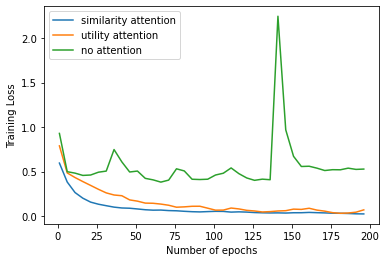

In [ ]:
plt.figure()
plt.plot(hist_no_att['epochs'],loss_transf1, label="similarity attention")
plt.plot(hist_no_att['epochs'],hist_att['loss'], label="utility attention")
plt.plot(hist_no_att['epochs'],hist_no_att['loss'],label="no attention")



lines = plt.gca().get_lines()
include = [0,1,2]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=0)

plt.ylabel('Training Loss')
plt.xlabel('Number of epochs')
plt.savefig('loss.png')
plt.show()

